In [2]:
#Samuel Ghebreyesus
#12/2/2022

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#importing necessary libraries

!pip install torchvision 
import torch
import torchvision

In [4]:
# Problem 1
# defining hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
# creating a dataloader that reads in the MNIST files for train and test set and does normalization on them 
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [6]:
# taking a look at some examples from test_loader dataset
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
# get shape
example_data.shape

torch.Size([1000, 1, 28, 28])

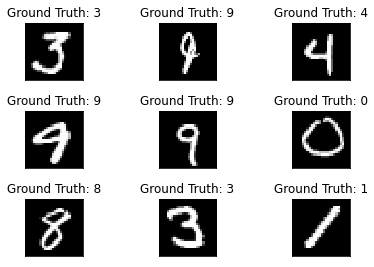

In [264]:
# nine example outputs and their labels as generated by your network
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

In [267]:
# importing necessary libraries for building network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [268]:
# building neural network with 2 convolutional layers, a dropout layer and  two fully connected layers, using relu and 
# max_pool
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [269]:
# initializing network and optimizer
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [270]:
# initializing train_losses/counter and test_losses/counter
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [271]:
# training loop method, takes in an epoch, prints out the loss for each train epoch
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad() # set gradients to zero
    output = network(data) # forward pass
    loss = F.nll_loss(output, target) # loss metric
    loss.backward() #collect a new set of gradients which we propagate back into each of the network's parameters, using 
                    #optimizer.step()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'C:/Users/samgh/Downloads/results/model.pth')
      torch.save(optimizer.state_dict(), 'C:/Users/samgh/Downloads/results/optimizer.pth')

In [272]:
# test loop method, prints out average loss for test set and accuracy
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [273]:
# calling train/test functions 
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\samgh\AppData\Local\Temp/ipykernel_11332/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3113, Accuracy: 769/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.346644
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.285905
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.283081
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.277860
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.251845
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.247523
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.176661
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.208258
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.182449
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.077577
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.878816
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.972748
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.865740
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.767948
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.732412
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.504338
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.557735
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.332809
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.334078
Train Epoch: 1 [12160/6

Text(0, 0.5, 'negative log likelihood loss')

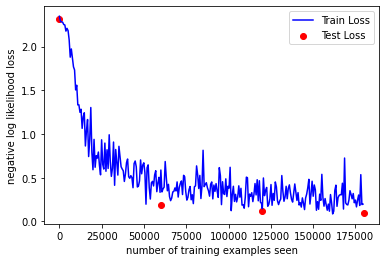

In [274]:
# plot training/testing error
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [275]:
# taking a look at some example data 
with torch.no_grad():
  output = network(example_data)

C:\Users\samgh\AppData\Local\Temp/ipykernel_11332/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


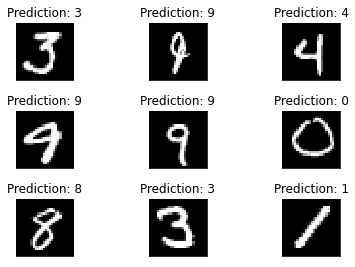

In [276]:
# nine example outputs and their labels as generated by your network
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [277]:
# extending the network 
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [278]:
# load internal state of network/optimizer when we last saved them 
network_state_dict = torch.load('C:/Users/samgh/Downloads/results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('C:/Users/samgh/Downloads/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [279]:
# running more epochs
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\samgh\AppData\Local\Temp/ipykernel_11332/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.145227
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.149400
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.158650
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.182935
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.268711
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.367966
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.174188
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.219948
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.220496
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.116969
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.171990
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.394427
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.309619
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.430836
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.364949
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.177536
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.350352
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.221092
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.194961
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.191531
Train Epoch: 4 [12800/60000 (

Text(0, 0.5, 'negative log likelihood loss')

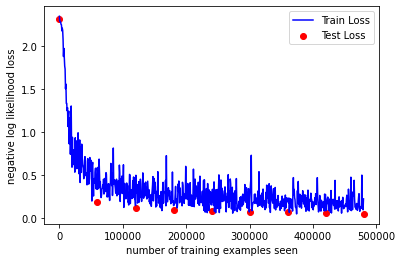

In [280]:
# plot training/testing error
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

In [23]:
# Problem 2

# importing necessary libraries 
!pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import time
import pandas as pd
import json
from IPython.display import clear_output
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)

# using fashion mnist dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [24]:
# put all hyperparameters for the three dimensions I'm investigating into an ordereddict
import collections
from collections import OrderedDict
params = OrderedDict(
    lr = [.0001, .001, 0.15, 0.2],
    batch_size = [100, 250, 500, 1000],
    dropout_rate = [0.4, 0.6, 0.7, 0.8]
)
n_epochs = 3

In [25]:
from collections import namedtuple
from itertools import product

# Builds run execution sets based on a dictionary of hyperparameters 
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

In [26]:
#class helps track loss, accuracy, epoch time, run time, hyper-parameters etc. Also record to TensorBoard and write 
# into csv, json
class RunManager():
  def __init__(self):

    # tracking epoch count, loss, accuracy
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    #tracking every run count, run data and hyperparameters used
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None
 
    # record model, loader and tensorboard
    self.network = None
    self.loader = None
    self.tb = None
    
 `# record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard
  def begin_run(self, run, network, loader):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.tb = SummaryWriter(comment=f'-{run}')

    images, labels = next(iter(self.loader))
    grid = torchvision.utils.make_grid(images)

    self.tb.add_image('images', grid)
    self.tb.add_graph(self.network, images)

   # close tensorboard, zero epoch count at end of each run
  def end_run(self):
    self.tb.close()
    self.epoch_count = 0

    #zero epoch count, loss, accuracy
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

  def end_epoch(self):
    # calculate epoch duration
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # calculate loss, accurracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    # put loss and accuracy in tensorboard
    self.tb.add_scalar('Loss', loss, self.epoch_count)
    self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)

    # record parameters in tensorboard
    for name, param in self.network.named_parameters():
      self.tb.add_histogram(name, param, self.epoch_count)
      self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
    
    # for all runs, put the results in ordereddict
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # put hyperparams into results
    for k,v in self.run_params._asdict().items(): 
        results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    clear_output(wait=True)
    display(df)

    #keep track of loss across entire epoch
  def track_loss(self, loss):
    self.epoch_loss += loss.item() * self.loader.batch_size
    
    # keep track of number of correct classifications
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()
  
    # save results into csv, json
  def save(self, fileName):

    pd.DataFrame.from_dict(
        self.run_data, 
        orient = 'columns',
    ).to_csv(f'{fileName}.csv')

    with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
      json.dump(self.run_data, f, ensure_ascii=False, indent=4)

In [27]:
m = RunManager()

# gets all params from RunBuilder class 
for run in RunBuilder.get_runs(params):

    network = Net()
    loader = torch.utils.data.DataLoader(train_set, batch_size = run.batch_size)
    optimizer = optim.SGD(network.parameters(), lr=run.lr, momentum = momentum)

    m.begin_run(run, network, loader)
    for epoch in range(n_epochs):
      
      m.begin_epoch()
      for batch in loader:
        
        images = batch[0]
        labels = batch[1]
        preds = network(images)
        loss = F.nll_loss(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        m.track_loss(loss)
        m.track_num_correct(preds, labels)

      m.end_epoch()
    m.end_run()
    
# save results to files
m.save('results')

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,dropout_rate
0,1,1,2.304900,0.097633,25.604221,26.027066,0.0001,100,0.4
1,1,2,2.303068,0.102017,23.707237,49.832035,0.0001,100,0.4
2,1,3,2.301980,0.105133,22.424883,72.334706,0.0001,100,0.4
3,2,1,2.307537,0.099867,22.488711,22.664230,0.0001,100,0.6
4,2,2,2.306243,0.104183,23.085083,45.827103,0.0001,100,0.6
...,...,...,...,...,...,...,...,...,...
187,63,2,0.891003,0.664300,25.584711,48.856976,0.2000,1000,0.7
188,63,3,0.771774,0.713083,23.373298,72.311053,0.2000,1000,0.7
189,64,1,1.563306,0.413050,22.838142,24.016929,0.2000,1000,0.8
190,64,2,0.888818,0.662833,22.308603,46.412295,0.2000,1000,0.8


In [40]:
# used this code to see all the rows and columns of dataframe
pd.set_option('display.max_rows', None)
df = pd.read_csv("results.csv")
df = df.iloc[: , 1:]
df

,run,epoch,loss,accuracy,epoch duration,run duration,lr,batch_size,dropout_rate
0,1,1,2.304900,0.097633,25.604221,26.027066,0.0001,100,0.4
1,1,2,2.303068,0.102017,23.707237,49.832035,0.0001,100,0.4
2,1,3,2.301980,0.105133,22.424883,72.334706,0.0001,100,0.4
3,2,1,2.307537,0.099867,22.488711,22.664230,0.0001,100,0.6
4,2,2,2.306243,0.104183,23.085083,45.827103,0.0001,100,0.6
5,2,3,2.305141,0.106050,22.298339,68.198246,0.0001,100,0.6
6,3,1,2.303113,0.105933,23.110017,23.314461,0.0001,100,0.7
7,3,2,2.300180,0.107600,22.738364,46.122633,0.0001,100,0.7
8,3,3,2.298275,0.109133,22.751862,68.960260,0.0001,100,0.7
9,4,1,2.309447,0.090050,22.483725,22.685174,0.0001,100,0.8


In [256]:
# Problem 3

from torch.optim import lr_scheduler
import sys

# greek dataset transform
class GreekTransform:
    def __init__(self):
        pass
    def __call__(self, x):
        x = torchvision.transforms.functional.rgb_to_grayscale(x)
        x = torchvision.transforms.functional.affine(x, 0, (0,0), 36/128, 0)
        x = torchvision.transforms.functional.center_crop(x, (28, 28))
        return torchvision.transforms.functional.invert(x)

    # function used to build the neural network for greek dataset, taking in a model path and a number
    # of output classes
def buildGreekNetwork(model_path, num_output_classes):
    network = Net()
    
    network_state_dict = torch.load(model_path)
    network.load_state_dict(network_state_dict)
    print("Trained network: ")
    print(network)
    
    for param in network.parameters():
        param.requires_grad = False
    num_features = network.fc2.in_features
    network.fc2 = nn.Linear(num_features, num_output_classes)
    print("Adjusted network: ")
    print(network)
    return network

# function for training that takes in number of epochs, network, train dataset using dataloader, optimizer and train 
# losses/counters as well as log interval
def train(epoch, network, train_loader, optimizer, log_interval, train_losses, train_counter):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
          train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          torch.save(network.state_dict(), 'C:/Users/samgh/Downloads/results2/model.pth')
          torch.save(optimizer.state_dict(), 'C:/Users/samgh/Downloads/results2/optimizer.pth')
    torch.save(network.state_dict(), 'C:/Users/samgh/Downloads/results3/model-%03d-%03d.pth' % (batch_idx, epoch))
    torch.save(optimizer.state_dict(), 'C:/Users/samgh/Downloads/results3/optimizer-%03d-%03d.pth' % (batch_idx, epoch))
    return

# function for testing that takes in network, test dataset using dataloader, test losses/counter
def test(network, test_loader, test_losses, test_counter):
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# the function we call to run the network and print out the results. takes in filepath for the model, train dataset
# and test dataset
def main(model_path, train_path, test_path):
    
    # DataLoader for the Greek data set
    greek_train = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder("C:/Users/samgh/Downloads/greek_train/greek_train",
                                         transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                                                     GreekTransform(), 
                                                                                     torchvision.transforms.Normalize(
                                                                                           (0.1307,), (0.3081,) ) ] ) ),
        batch_size = 5,
        shuffle = True )
    
    greek_test = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder("C:/Users/samgh/Downloads/greek_train/greek_train",
                                         transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                                                     GreekTransform(), 
                                                                                     torchvision.transforms.Normalize(
                                                                                           (0.1307,), (0.3081,) ) ] ) ),
        batch_size = 27,
        shuffle = False )
    
    network = buildGreekNetwork(model_path, 3)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr = 0.001, momentum = 0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    device = "cpu"
    dataset_sizes = {'train':len(greek_train) }
    train_losses = []
    train_counter = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(18)]
    
    for epoch in range(17):
        test_counter.append(epoch*len(train_loader.dataset))
        train(epoch, network, greek_train, optimizer, 3, train_losses, train_counter)
        test(network, greek_test, test_losses, test_counter)
    
    examples = enumerate(greek_test)
    batch_idx, (example_data, example_targets) = next(examples)
    print(example_data.shape)
    
    with torch.no_grad():
        network.eval()
        output = network(example_data)
        
    fig = plt.figure()
    for i in range(27):
        plt.subplot(6, 5, i+1)
        plt.tight_layout()
        plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
        plt.title("Prediction: %d" % (output.data.max(1, keepdim=True)[1][i].item()))
        plt.xticks([])
        plt.yticks([])
    plt.show()

Trained network: 
Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)
Adjusted network: 
Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=3, bias=True)
)
Train Epoch: 0 [0/27 (0%)]	Loss: 1.284276
Train Epoch: 0 [15/27 (50%)]	Loss: 1.361020


C:\Users\samgh\AppData\Local\Temp/ipykernel_11332/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 1.1357, Accuracy: 9/27 (33%)

Train Epoch: 1 [0/27 (0%)]	Loss: 1.326597
Train Epoch: 1 [15/27 (50%)]	Loss: 1.372637

Test set: Avg. loss: 1.1041, Accuracy: 11/27 (41%)

Train Epoch: 2 [0/27 (0%)]	Loss: 0.970230
Train Epoch: 2 [15/27 (50%)]	Loss: 1.126079

Test set: Avg. loss: 1.0643, Accuracy: 14/27 (52%)

Train Epoch: 3 [0/27 (0%)]	Loss: 1.023785
Train Epoch: 3 [15/27 (50%)]	Loss: 0.896698

Test set: Avg. loss: 1.0264, Accuracy: 16/27 (59%)

Train Epoch: 4 [0/27 (0%)]	Loss: 1.093926
Train Epoch: 4 [15/27 (50%)]	Loss: 1.122043

Test set: Avg. loss: 0.9869, Accuracy: 16/27 (59%)

Train Epoch: 5 [0/27 (0%)]	Loss: 0.889540
Train Epoch: 5 [15/27 (50%)]	Loss: 1.265316

Test set: Avg. loss: 0.9443, Accuracy: 18/27 (67%)

Train Epoch: 6 [0/27 (0%)]	Loss: 0.905370
Train Epoch: 6 [15/27 (50%)]	Loss: 0.902990

Test set: Avg. loss: 0.9007, Accuracy: 21/27 (78%)

Train Epoch: 7 [0/27 (0%)]	Loss: 0.987156
Train Epoch: 7 [15/27 (50%)]	Loss: 0.974100

Test set: Avg. loss: 0.8633

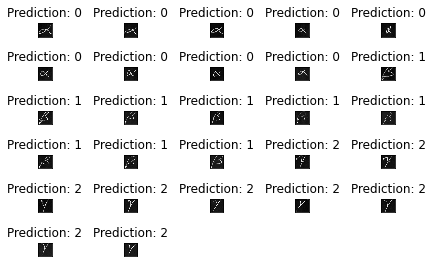

In [257]:
# call main to get results printed out
main("C:/Users/samgh/Downloads/results/model.pth", "C:/Users/samgh/Downloads/greek_train/greek_train", "C:/Users/samgh/Downloads/greek_train/greek_train")

Text(0, 0.5, 'negative log likelihood loss')

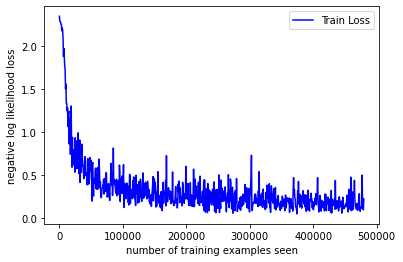

In [281]:
# plot train error
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')